<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">


---
<h3>Jon Amelibia, Iker Cumplido, Aitor Hernandez, Daniel Puente and Iñigo Ugarte

## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Transform data to introduce it in RRNN<ins></a>
- <a href='#3'><ins>3. Custom loss function<ins> </a>
- <a href='#4'><ins>4. Save data<ins> </a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from itertools import chain

import warnings
warnings.filterwarnings('ignore')

Main variables

In [3]:
path_origin, path_processed = "../02_data/original_data/", "../02_data/processed_data/"
models_path = "../03_models/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

Processed dataset      
We process the data, changing the type to float and removing the negatives

In [4]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
df_desc_final_pickle_not_index = df_desc_final_pickle.reset_index(col_level=0)
print(df_desc_final_pickle.shape)

(390, 41)


### <a id='2'>2. Transform data to introduce it in RRNN</a>
---

In [5]:
def x_and_y(df_desc_final_pickle, num_steps = 10, index = False):
    x, y, quantiles_final, new_values = [], [], [], []

    for i in range(1, 9):
        if index:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.cell == i]
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):
                x.append(np.array(batery_df.iloc[slice(j,num_steps+j), 1:].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.iloc[slice(j,num_steps+j), 1:].RUL.values[-1], i]))
                quantiles.append(i)
        else:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
            batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):

                x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1], i]))
                quantiles.append(i)

        quantiles_final.append(np.array_split(range(len(quantiles)), 4))
            
    x, y = np.array(x), np.array(y)

    for j in np.unique(y[:,1]):
        batery_column = y[:,1][y[:,1] == j]
        new_values.append([i+1 for i in range(4) for x in batery_column[quantiles_final[int(j-1)][i]].tolist()])
    y = np.append(y, np.array(list(chain(*new_values))).reshape(-1,1), axis = 1)
    y[:,0] = y[:,0].astype(float)
    print(x.shape, y.shape)
    return x, y

In [6]:
x, y = x_and_y(df_desc_final_pickle, num_steps = 10, index = False)

(302, 11, 40) (302, 3)


We split the data into train and test sets, and then we scale the data.

In [7]:
# X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1]])
X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1,2]])

y_train, y_test = y_train_mod[:,0].reshape(-1,1), y_test_mod[:,0].reshape(-1,1)

# X_train,X_test,y_train,y_test = train_test_split(x, y,test_size=0.2, random_state=42)

X_train = np.stack(X_train, axis = 0)
y_train = np.stack(y_train, axis = 0)

X_test = np.stack(X_test, axis = 0)
y_test = np.stack(y_test, axis = 0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

### <a id='3'>3. Custom loss function</a>
---

A loss function is created in order to penalisize the model when the prediction is greater than the real value.

In [8]:
def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    return K.mean(K.square(diff))*greater

def customLoss_numpy(true,pred):
    diff = pred - true
    greater = np.max(diff)
    greater = greater + 1     
    return np.mean(greater*(diff**2))

We apply the created function to small numbers to see the difference between the classic rmse and the customed one.

In [9]:
float_numbers = [x/100 for x in range(1,301)]
lista_mse, lista_mse_2 = [], []
for i in float_numbers:
    lista_mse.append(mean_squared_error([0], [i]))
    lista_mse_2.append(customLoss_numpy(np.array([0]),np.array([i])))  

We can see that out function is working as expected, penalizing more the errors when the true value is higher than the predicted value.

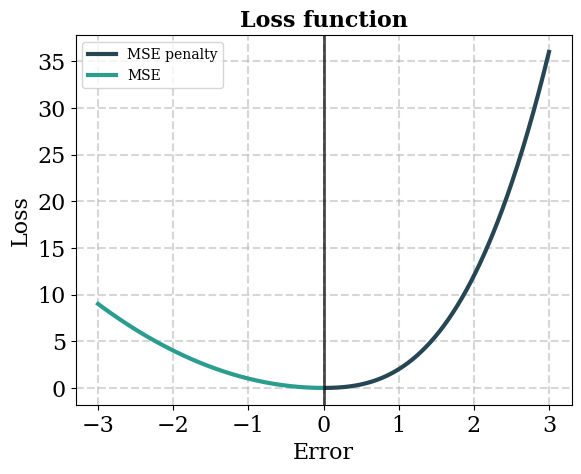

In [10]:
plt.plot(float_numbers, lista_mse_2, label='MSE penalty', color=palette[0], linewidth=3)
plt.plot(-np.array(float_numbers), lista_mse, label='MSE', color=palette[1], linewidth=3)
plt.legend(), plt.xticks(fontsize=16, family='serif'), plt.yticks(fontsize=16, family='serif'), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
plt.xlabel('Error', fontsize=16, family='serif'), plt.ylabel('Loss', fontsize=16, family='serif'), plt.title('Loss function', fontsize=16, fontweight='bold', family='serif');
plt.axvline(x=0, color='black', linewidth=2, alpha = 0.7);
for text in plt.gca().get_legend().get_texts():
    plt.setp(text, family='serif')

### <a id='4'>4. Models</a>
---

#### **LSTM**


In [11]:
np.random.seed(26), tf.random.set_seed(26)
early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_first_model_LSTM = keras.callbacks.ModelCheckpoint(models_path +'first_model_LSTM.h5', verbose=0, save_best_only=True)

model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)
])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=customLoss, optimizer=optimizer, metrics=['mae'])
history = model.fit(X_train, y_train, epochs=20000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_LSTM, early_stopping])

#### **GRU**  

In [ ]:
np.random.seed(26), tf.random.set_seed(26)
early_stopping = keras.callbacks.EarlyStopping(patience=10000, restore_best_weights=True, monitor='val_loss')
first_model_GRU_without_neg = keras.callbacks.ModelCheckpoint(models_path +'first_model_GRU.h5', verbose=0, save_best_only=True)

model2 = keras.Sequential([
    keras.layers.GRU(624, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.GRU(416),
    keras.layers.Dense(1, activation='relu')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(loss=customLoss, optimizer='adam', metrics=['mae'])
historyW = model2.fit(X_train, y_train, epochs=50000, batch_size=32, validation_split=0.2, verbose=0, shuffle=False, callbacks=[first_model_GRU_without_neg, early_stopping])

#### **Bidirectional LSTM**

In [12]:
np.random.seed(26), tf.random.set_seed(26);
early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint(models_path + 'Bidirectional_LSTM_adapted.h5', verbose = 0, save_best_only=True)

model_lstm_bidirectional = keras.Sequential()
forward_layer = keras.layers.LSTM(624, activation = keras.layers.LeakyReLU(alpha=0.3), recurrent_dropout = 0.05)
backward_layer = keras.layers.LSTM(416, activation = tf.keras.layers.PReLU('zeros'), recurrent_dropout = 0.05, go_backwards = True)
model_lstm_bidirectional.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model_lstm_bidirectional.add(keras.layers.Dense(1, activation='relu'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_bidirectional.compile(loss=customLoss, optimizer= optimizer, metrics=['mae'])
historyBiLSTM = model_lstm_bidirectional.fit(X_train, y_train, epochs=20000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping])

In [13]:
np.argmin(historyBiLSTM.history['val_loss']), len(historyBiLSTM.history['val_loss'])

(727, 5728)

#### **Bidirectional GRU**

In [ ]:
np.random.seed(26), tf.random.set_seed(26);
early_stopping = keras.callbacks.EarlyStopping(patience=25000, restore_best_weights=True)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint(models_path +'Bidirectional_GRU.h5', verbose = 0, save_best_only=True)

model_lstm_bidirectional = keras.Sequential()
forward_layer = keras.layers.GRU(256)
backward_layer = keras.layers.GRU(256, go_backwards = True)
model_lstm_bidirectional.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model_lstm_bidirectional.add(keras.layers.Dense(1, activation='relu'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_lstm_bidirectional.compile(loss=customLoss, optimizer= optimizer, metrics=['mae'])
historyBiLSTM = model_lstm_bidirectional.fit(X_train, y_train, epochs=50000, batch_size=32, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping])

#### **Bidirectional GRU with RMSE loss function**    
With this model we optimize the RMSE loss function, and we can see that the results are better than the previous ones.

In [11]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=150, factor=0.5, min_lr=0.000005)
early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_new = keras.callbacks.ModelCheckpoint(models_path +'first_model_new.h5', verbose = 0, save_best_only=True)

model = keras.models.load_model(models_path + f'tryals_bidirectional_lstm_24.h5', custom_objects={'customLoss': customLoss})
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=rmse, optimizer=optimizer, metrics=['mae'])
np.random.seed(26), tf.random.set_seed(26);
historyBiLSTM = model.fit(X_train, y_train, epochs=10000, batch_size=16, validation_split=0.2, verbose=1, shuffle=False, callbacks=[checkpoint_new, early_stopping, reduce_lr])

Epoch 1/10000
12/12 [==============================] - 8s 479ms/step - loss: 188.4625 - mae: 150.1227 - val_loss: 104.9497 - val_mae: 73.9779 - lr: 1.0000e-04
Epoch 2/10000
12/12 [==============================] - 3s 244ms/step - loss: 115.3372 - mae: 90.8850 - val_loss: 109.2581 - val_mae: 96.3481 - lr: 1.0000e-04
Epoch 3/10000
12/12 [==============================] - 3s 279ms/step - loss: 91.1046 - mae: 67.5160 - val_loss: 54.3110 - val_mae: 42.0439 - lr: 1.0000e-04
Epoch 4/10000
12/12 [==============================] - 3s 293ms/step - loss: 78.6715 - mae: 61.1535 - val_loss: 45.8712 - val_mae: 32.3972 - lr: 1.0000e-04
Epoch 5/10000
12/12 [==============================] - 3s 251ms/step - loss: 65.9402 - mae: 50.8477 - val_loss: 58.1435 - val_mae: 41.0711 - lr: 1.0000e-04
Epoch 6/10000
12/12 [==============================] - 3s 260ms/step - loss: 88.2681 - mae: 67.8779 - val_loss: 95.7508 - val_mae: 73.5286 - lr: 1.0000e-04
Epoch 7/10000
12/12 [==============================] - 3s 2